# Notebook Regarding Discussion of $\bar{V_R^2}$

## Loading Data

In [1]:

import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
from data_plot import sample_distribution_galactic_coords, plot_radial_distribution, plot_distribution, display_polar_histogram, plot_variance_distribution, plot_velocity_distribution
import numpy as np
import emcee
from functools import reduce
import time, timeit
import transformation_constants
import datetime as dt
import photometric_cut
import os
import pickle
from pathlib import Path
import argparse
import random
import matplotlib.pyplot as plt


Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

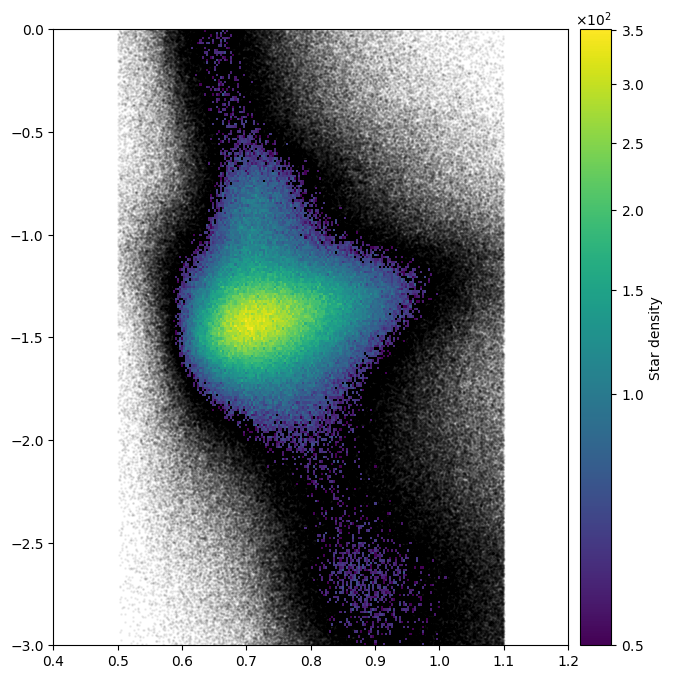

In [2]:

# Create outpath for current run
run_out_path = "/home/svenpoder/repos/gaia-tools/jupyter-notebook"

print("Photometric cut..")
sample_IDs = photometric_cut.get_sample_IDs(run_out_path, 0.3, False)

# The path containing the initial ICRS data with Bayesian distance estimates.
my_path = "/home/svenpoder/Gaia_2MASS Data_DR2/gaia_rv_data_bayes.csv"

# Import ICRS data
icrs_data = import_data(path = my_path, is_bayes = True, debug = True)
icrs_data = icrs_data.merge(sample_IDs, on='source_id', suffixes=("", "_y"))
icrs_data.reset_index(inplace=True, drop=True)

print("Size of sample after diagonal cut in ROI {}".format(icrs_data.shape))

## TRANSFORMATION CONSTANTS
v_sun = transformation_constants.V_SUN
z_0 = transformation_constants.Z_0
r_0 = transformation_constants.R_0

galcen_data = data_analysis.get_transformed_data(icrs_data,
                                       include_cylindrical = True,
                                       z_0 = z_0,
                                       r_0 = r_0,
                                       v_sun = v_sun,
                                       debug = True,
                                       is_bayes = True,
                                       is_source_included = True)

galactocentric_cov = cov.generate_galactocentric_covmat(icrs_data, True)
cyl_cov = cov.transform_cov_cylindirical(galcen_data, galactocentric_cov)
galcen_data = galcen_data.merge(cyl_cov, on='source_id')


# Final data selection
galcen_data = galcen_data[(galcen_data.r < 12000) & (galcen_data.r > 5000)]
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
galcen_data.reset_index(inplace=True, drop=True)
print("Final size of sample {}".format(galcen_data.shape))

icrs_data = icrs_data.merge(galcen_data, on='source_id')[icrs_data.columns]

min_r = np.min(galcen_data.r)
max_r = np.max(galcen_data.r)


In [ ]:
# Plots the velocity and velocity variance distribution of first 4 bins. 
plot_velocity_distribution(bin_collection.bins[0:4], run_out_path, True)
plot_variance_distribution(bin_collection.bins[0:4], 'v_phi', run_out_path)

In [3]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = min_r - 1,
                                                      BL_r_max = max_r + 1,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (10, 1),
                                                      r_drift = False,
                                                      debug = False)

In [4]:
bin_mids = []
for i, bin in enumerate(bin_collection.bins):
    bin_mids.append(np.median(bin.r_boundaries))

## XX Component Check

([<matplotlib.axis.XTick at 0x7f073b106430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

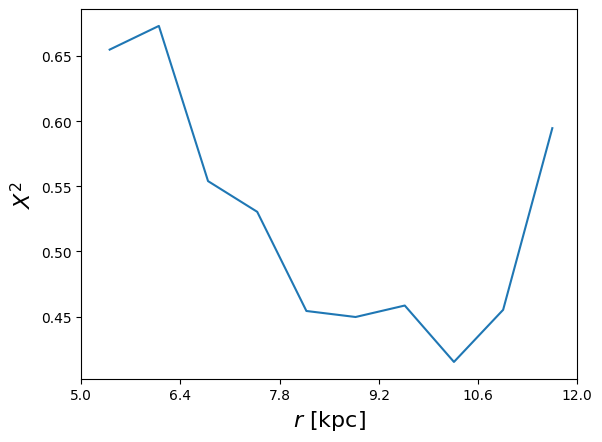

In [6]:
new_xx = []
for i, bin in enumerate(bin_collection.bins):
    nom = np.var(bin.data.v_phi)
    denom = np.mean(bin.data.v_r)**2 + np.var(bin.data.v_r)
    new_xx.append(nom/denom)
    #print(nom/denom)

plt.plot(np.array(bin_mids)/1000, new_xx)
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$X^2$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))

## Checking components in $\bar{v^2_R} = {\bar{v_R}}^2 + \sigma^2_R$

In [17]:
# Compute the variance and mean of v_r in bins

velocity_var = []
for i, bin in enumerate(bin_collection.bins):
    var_i = np.var(bin.data['v_r'])
    velocity_var.append(var_i)

mean_vel = []
for i, bin in enumerate(bin_collection.bins):
    mean_vel.append(np.mean(bin.data.v_r))
mean_vel = np.array(mean_vel)

### Checking $\sigma_R^2$ component

([<matplotlib.axis.XTick at 0x7f07391f1af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

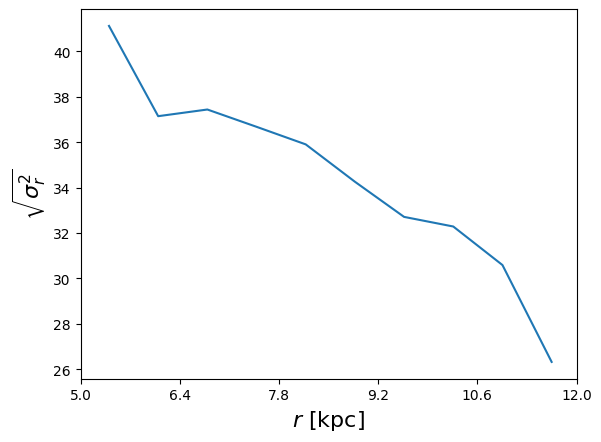

In [13]:
plt.plot(np.array(bin_mids)/1000, np.sqrt(velocity_var))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\sqrt{\sigma_r^2}$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))

([<matplotlib.axis.XTick at 0x7f073919cee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

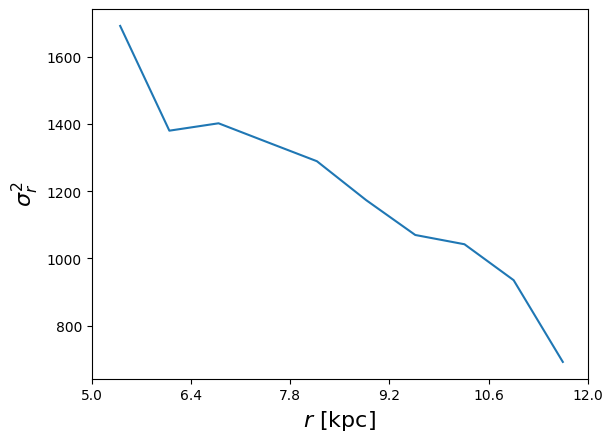

In [14]:
plt.plot(np.array(bin_mids)/1000, velocity_var)
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\sigma_r^2$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))

### Checking $\bar{v_R}^2$ component

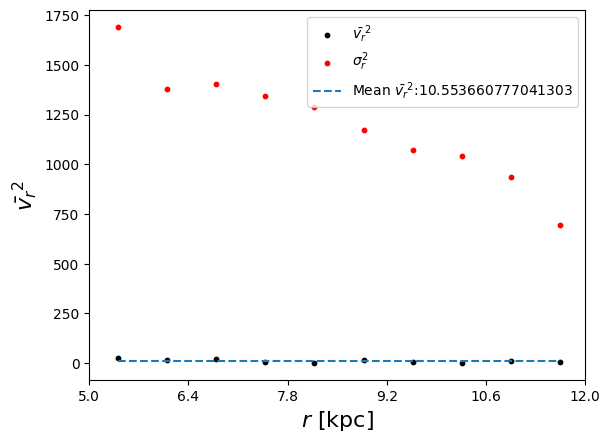

In [15]:
plt.scatter(np.array(bin_mids)/1000, mean_vel**2, s=10, color='black', label=r'$\bar{v_r}^2$')
plt.scatter(np.array(bin_mids)/1000, velocity_var, s=10, color='red', label=r'$\sigma^2_r$')

overall_mean = np.mean(mean_vel[~np.isnan(mean_vel)]**2)

plt.hlines(overall_mean, 
                    bin_mids[0]/1e3, bin_mids[-1]/1e3, 
                    linestyles='--', 
                    label="Mean " + r"$\bar{v_r}^2$:" + "{}".format(overall_mean))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\bar{v_r}^2$',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))
plt.legend()



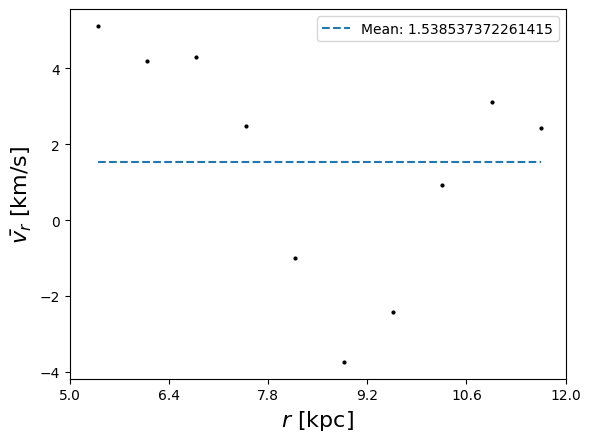

In [19]:
plt.scatter(np.array(bin_mids)/1000, mean_vel, s=4, color='black')

overall_mean = np.mean(mean_vel[~np.isnan(mean_vel)])

plt.hlines(overall_mean, 
                    bin_mids[0]/1e3, bin_mids[-1]/1e3, 
                    linestyles='--', 
                    label="Mean: {}".format(overall_mean))
plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
plt.ylabel(r'$\bar{v_r}$ [km/s]',  fontdict={'fontsize' : 16})
plt.xticks(np.linspace(5,12,6))
plt.legend()


In [ ]:
for bin in bin_collection.bins:
    print(bin.data.shape)

## Astropy Sanity Check

In [ ]:
import astropy.coordinates as coord
import astropy.units as u

icrs_star = icrs_data.iloc[0]

c1 = coord.SkyCoord(ra=icrs_star.ra*u.degree, 
                    dec=icrs_star.dec*u.degree,
                    distance=icrs_star.r_est*u.pc,
                    pm_ra_cosdec=icrs_star.pmra*u.mas/u.yr,
                    pm_dec=icrs_star.pmdec*u.mas/u.yr,
                    radial_velocity=icrs_star.radial_velocity*u.km/u.s,
                    frame='icrs')

In [ ]:
v_sun = [-11.1, 232.24, 7.25]* (u.km / u.s)

gc_frame = coord.Galactocentric(galcen_distance=8.178*u.kpc,
    galcen_v_sun=v_sun,
    z_sun=17*u.pc)

gc1 = c1.transform_to(gc_frame)
gc1

In [ ]:
coord.Galactocentric()

In [ ]:
print(galcen_data.iloc[0])

## Velocity Ellipsoid

In [ ]:
def cov(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    return np.sum((x-x_mean)*(y-y_mean))/(len(x) - 1)

def cov_mat(bin):
    return np.array([[cov(bin.data.v_r, bin.data.v_r), cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_r, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_z), cov(bin.data.v_phi, bin.data.v_z), cov(bin.data.v_z, bin.data.v_z)]])

### Compute vertex deviation

In [ ]:
def compute_vertex_deviation(velocity_ellipsoid):

    vel_ell_comps = velocity_ellipsoid[0,1]/(velocity_ellipsoid[0,0] - velocity_ellipsoid[1,1])
    vertex_dev = np.arctan(2 * (vel_ell_comps))/2 

    # Returns in radians
    return vertex_dev

In [ ]:
velocity_ellipsoids = []
vertex_devs = []
for i, bin in enumerate(bin_collection.bins):
    velocity_ellipsoids.append(cov_mat(bin))
    vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
    vertex_devs.append(vertex_dev)

In [ ]:
np.degrees(np.mean(vertex_devs))

In [ ]:
def plot_vertex_deviations(bin_collection):

    velocity_ellipsoids = []
    vertex_devs = []
    for i, bin in enumerate(bin_collection.bins):
        velocity_ellipsoids.append(cov_mat(bin))
        vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
        vertex_devs.append(vertex_dev)

    fontdict = {'fontsize' : 15}

    fig, axs = plt.subplots(1,2,figsize = (14, 7))

    axs[0].plot(np.array(bin_mids)/1000, np.array(velocity_ellipsoids)[:,0,1])
    axs[0].vlines(bin_collection.bin_boundaries[0][0]/1000, 
                np.min(np.array(velocity_ellipsoids)[:,0,1]), 
                np.max(np.array(velocity_ellipsoids)[:,0,1]),
                linestyles='--', color='gray')

    axs[0].set_ylabel(r'$\sigma_{R\phi}^2$', fontdict=fontdict, labelpad=0)
    axs[0].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[0].tick_params(axis='both', which='major', labelsize=15)

    vertex_devs = []
    for i, bin in enumerate(bin_collection.bins):
        vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
        vertex_devs.append(vertex_dev)

    axs[1].plot(np.array(bin_mids)/1000, np.degrees(vertex_devs))
    axs[1].vlines(bin_collection.bin_boundaries[0][0]/1000, 
                np.min(np.degrees(vertex_devs)), 
                np.max(np.degrees(vertex_devs)),
                linestyles='--', color='gray')
    axs[1].set_ylim(-10,8.5)

    axs[1].set_ylabel('Vertex Deviation', fontdict=fontdict, labelpad=-5)
    axs[1].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[1].tick_params(axis='both', which='major', labelsize=15)

plot_vertex_deviations(bin_collection)